<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Triggers" data-toc-modified-id="Triggers-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Triggers</a></span></li></ul></div>

# Triggers

If large signal traces are captured, it's useful to be able to find portions where particular things happen.
*Triggers* are used for this.
These are analogous to the trigger function on logic analyzers and oscilloscopes.

Triggers are created by performing operations on `Trace` objects.
A `Trace` is just a list of values for a signal and the times at which they occurred.
Every `Peeker` object contains a `Trace` to record the values observed by the `Peeker`.

Arithmetic (`+, -, *, %, /, //, **, <<, >>, abs`), logical (`&, |, ^, ~`), and comparison (`==, !=, <, >, <=, >=`) operations
can be performed on `Trace` and `Peeker` objects to create a new `Trace` as a result:

    <Trace|Peeker> op <Trace|Peeker|integer|float> => Trace

There is also a `delay()` method for creating a time-shifted version of a `Trace` (useful for
detecting edges):

    <Trace|Peeker>.delay(<integer>) => Trace

The times at which the resulting trace is `True` (i.e., non-zero) can be extracted as a list:

    <Trace|Peeker>.trig_times() => [t0, t1, ...]

These time values can be used to set the `start_time` parameter when displaying waveforms or tables:

    trigs = trc.trig_times()
    show_waveforms(..., start_time=trigs[0])

I'll demonstrate the creation of triggers using `Trace` objects containing random values.
(These same operations can be performed on `Peeker` objects;
it's just easier to create a `Trace`.)

First, I'll create some random traces:

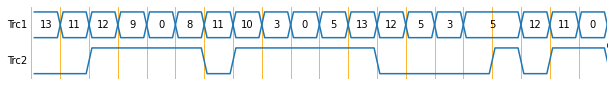

In [1]:
from random import randrange
from myhdlpeek import *

def create_random_trace(name, num_bits, num_samples):
    trace = Trace()
    trace.name = name
    trace.num_bits = num_bits
    for i in range(num_samples):
        trace.append(Sample(i, randrange(0,2**num_bits)))
    return trace

trc1 = create_random_trace('Trc1', 4, 100)
trc2 = create_random_trace('Trc2', 1, 100)

show_traces(trc1, trc2, stop_time=20)

A common trigger is to look for a positive-going edge on a signal.
This can be done by logically-ANDing the signal to a time-delayed and inverted version of itself:

Trigger times: [2, 7, 16, 18, 21, 29, 31, 33, 37, 40, 42, 46, 50, 56, 61, 66, 70, 74, 77, 80, 83, 90, 94, 99]


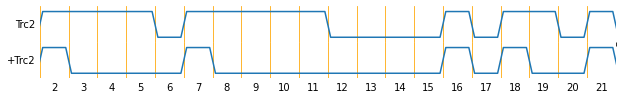

In [2]:
posedge_trc = trc2 & ~trc2.delay(1)    # Create trigger trace that is 1 whenever trc2 has a rising edge.
posedge_trc.name = '+Trc2'
trigs = posedge_trc.trig_times()       # Get times at which the trigger trace is 1.
print('Trigger times:', trigs)
start_time = trigs[0]                  # Start waveform display at the first trigger.
stop_time = start_time+20              # Stop waveform display after 20 time units.
show_traces(trc2, posedge_trc, start_time=start_time, stop_time=stop_time, tock=True)

Naturally, there are convenience functions for these common cases: `posedge()`, `negedge()` and `anyedge()`:

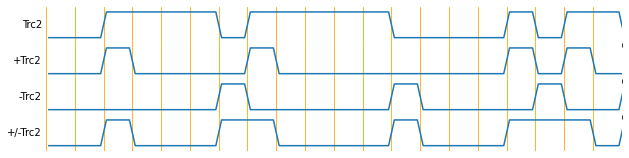

In [3]:
posedge_trc = trc2.posedge(); posedge_trc.name = '+Trc2'
negedge_trc = trc2.negedge(); negedge_trc.name = '-Trc2'
anyedge_trc = trc2.anyedge(); anyedge_trc.name = '+/-Trc2'
show_traces(trc2, posedge_trc, negedge_trc, anyedge_trc, stop_time=20)

Another common trigger is to look for when a bus has a certain value:

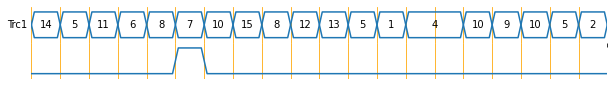

In [4]:
val_trc = trc1 == 7  # Create a trigger trace that is 1 whenever trc1 has the value 7.
trigs = val_trc.trig_times()
show_traces(trc1, val_trc, start_time=trigs[0]-5, stop_time=trigs[0]+15)

Or detect when a bus is between two values:

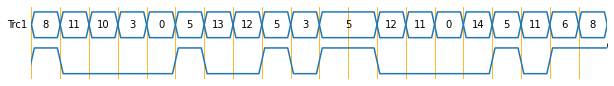

In [5]:
val_trc = (5 <= trc1) & (trc1 <= 8)  # Trigger when trace value is in range [5,8].
trigs = val_trc.trig_times()
show_traces(trc1, val_trc, start_time=trigs[0], stop_time=trigs[0]+20)

Or trigger when several bits of a bus have a certain value:

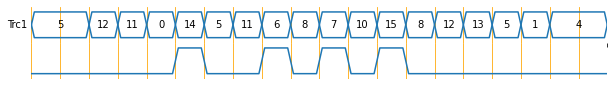

In [6]:
bit_val_trc = ((trc1 & 0b0110)>>1) == 3 # Trigger when bits 1 and 2 are both on (trc1 is 6, 7, 14 or 15).
trig = bit_val_trc.trig_times()[0]
show_traces(trc1, bit_val_trc, start_time=trig-5, stop_time=trig+15)

Complicated triggers are possible. Here's one that triggers when consecutive bus values differ by more than 10:

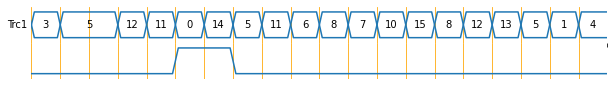

In [7]:
diff_trc = (abs(trc1 - trc1.delay(1))) > 10
trig = diff_trc.trig_times()[0]
show_traces(trc1, diff_trc, start_time=trig-5, stop_time=trig+15)

Since the output of operations on `Trace`s is another `Trace`, it's possible to
concatenate several operations to get a concise trigger expression:

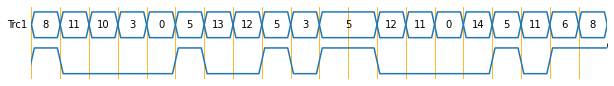

In [8]:
trig = ((5 <= trc1) & (trc1 <= 8)).trig_times()[0]
show_traces(trc1, val_trc, start_time=trig, stop_time=trig+20)